## NBA Tweets: Natural Language Processing and Network Analysis

MSDA Data 620 Final Project 

Team 4 - John Grando, Nick Capofari, Ken Markus, Armenoush Aslanian-Persico, Andrew Goldberg



[Header image/logo] /////////////////////////////////////////

### Part 1: Introduction

[Explanation of the NBA, Teams, Players, potential networks; why this interests us; how we selected our group of 23 Twitter users and what their significance is; what we expect to find or answer; about the NBA season/offseason; influence of these individuals]

YouTube walkthroughs of this project are available here:

Data acquisition: https://youtu.be/onedOIidyU0

Natural Language Processing: 

Network analysis:

### Part 2: Data acquisition

We collected recent tweets from the most active NBA players (and associates) via the Twitter Search API. The API allows for basic search queries (e.g. to: or from: a specific handle, or containing a specific hashtag). However, there are certain limitations with the public-facing API:

-Results are limited to the last 7 days

-Return sets are limited in size, the documentation states only 7 tweets are returned in each query; however in practice we were able to pull upwards of 50 tweets per query.

An alternative to Twitter’s Search API is their Streaming API, which returns real-time results. We attempted to leverage this option, however the result sets were actually smaller because the players and associates were simply not active enough on Twitter to yield more results.

Once tokens were acquired, performing the data pulls proved relatively simple. We leveraged package SocialMediaLab to facilitate the formatting of the data. This package contains wrappers for Facebook and Instagram APIs in addition to Twitter. The encapsulation of credentials, and formatting of tweet data are the primary benefits.

The output data derives from the twitteR package, of the status-class class.

#### Field data dictionary

The below are variable fields available in the API pull data.

text: The text of the status.

screenName: Screenname of the user who posted the status.

id: ID of the status.

replyToSN: Screen name of the user this is in reply to.

replyTOUID: ID of the user this was in reply to.

statusSource: Source user agent for this tweet.

created: When this status was created.

truncated: Whether this status was truncated.

favorited: Whether this status has been favorited.

retweeted: TRUE if this status has been retweeted.

retweetCount: The number of times this status has been retweeeted.

<a href="https://github.com/kennygfm/Data620/blob/master/Team4_FinalProject_buildTwitterDataFrame_V7.9.R">View source code on github.</a>


### Part 3: Data setup and packages

In [47]:
%%javascript

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('m', { 
    // # added keyboard shortcut for Jupyter - Ctrl+M, then m runs all cells
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [48]:
import networkx as nx
import networkx.algorithms
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import pylab as py
import nltk

from networkx.algorithms.components.connected import connected_components
from scipy.spatial import distance
from scipy.cluster import hierarchy
from collections import defaultdict

% matplotlib inline

### Part 4: Natural Language Processing

[Introduction to NLP section]***************************************


In [ ]:
playerdf = pd.read_csv("playerList.csv")
tweetdf = pd.read_csv("Top20Tweets_and_Teams_and_Ancillary.csv")
#print playerdf, tweetdf

In [ ]:
maindf = tweetdf.merge(playerdf, how='left', left_on="from_user", right_on="handle")
#Check if there are any nulls or NaNs in the joined data.
print maindf.isnull().sum()

In [ ]:
import re
tweetlist = []
for index, row in maindf.iterrows():
    uni_list = []
    word_list = []
    hashtag_list = []
    mention_list = []
    #get just unicode tags
    uni_list = [i for i in re.findall(r'[^\w\s,!@#/\.\:\'\"]', row["text"].decode("utf8"))]
    #get words
    word_list = [re.sub('[\W]+','', word).lower() for word in row["text"].decode("utf8").split() if word[0].isalnum()]
    #get hashtags
    hashtag_list = [word for word in row["text"].decode("utf8").split() if word[0].startswith("#")]
    #get mentions
    mention_list = [word for word in row["text"].decode("utf8").split() if word[0].startswith("@")]
    #recombine them all and add a tag
    tweetlist.append(((uni_list + word_list + hashtag_list + mention_list, row["retweetCount"], 
                      row["users_mentioned"],row["hashtags_used"]), row["active"]))
import random
random.seed(222)
random.shuffle(tweetlist)
#print tweetlist[23]

In [ ]:
def twitter_features(tweet, tweetcount, users_mentioned, hashtags_used):
    tweet_words = set(tweet)
    features = {}
    #if nothing is returned from the tweetlist, it's a nan, so I used the isintance(x, float) method to filter.
    if not isinstance(users_mentioned, float):
        if len(users_mentioned.split(","))>1:
            features["num_instances({})".format("mentioned_more_than_one")] = True
        else:
            features["num_instances({})".format("mentioned_more_than_one")] = False
    else:
        features["num_instances({})".format("mentioned_more_than_one")] = False
    if int(tweetcount) > 1000:
        features["num_instances({})".format("retweet_count_large")] = True
    else:
        features["num_instances({})".format("retweet_count_large")] = False
    if not isinstance(hashtags_used, float):
        if len(hashtags_used.split(","))>1:
            features["num_instances({})".format("hashtags_more_than_one")] = True
        else:
            features["num_instances({})".format("hashtags_more_than_one")] = False
    else:
        features["num_instances({})".format("hashtags_more_than_one")] = False
    if not isinstance(users_mentioned, float):
        for i in [um for um in users_mentioned.split(",")]:
            features["mentioned({})".format(str(i).strip())] = True
    if not isinstance(hashtags_used, float):
        for i in [hu for hu in hashtags_used.split(",")]:
            features["hashtag({})".format(str(i).strip())] = True
    return features

In [ ]:
featuresets = [(twitter_features(d, rc, um, hu), c) for ((d, rc, um, hu),c) in tweetlist]
train_set, dev_test_set, test_set = featuresets[:200], featuresets[200:400], featuresets[400:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [ ]:
print 'Accuracy: %4.2f' %nltk.classify.accuracy(classifier, dev_test_set)
classifier.show_most_informative_features(10)

In [ ]:
preds = pd.DataFrame({'observed':[classification for (email,classification) in dev_test_set],
                      'predicted': [classifier.classify(twitter_features(d, rc, um, hu)) 
                                    for ((d, rc, um, hu),c) in tweetlist[200:400]]})

In [ ]:
pd.crosstab(preds.observed,preds.predicted)

In [ ]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(preds.observed,preds.predicted)
sensitivity1 = (float(cm[1,1])/(cm[1,1]+cm[1,0]))
print('Sensitivity : ', sensitivity1 )

specificity1 = (float(cm[0,0])/(cm[0,0]+cm[0,1]))
print('Specificity : ', specificity1)

In [ ]:

print 'Accuracy: %4.2f' %nltk.classify.accuracy(classifier, test_set)
classifier.show_most_informative_features(10)

In [ ]:
perf = pd.DataFrame({'observed':[classification for (email,classification) in test_set],
                      'predicted': [classifier.classify(twitter_features(d, rc, um, hu)) 
                                    for ((d, rc, um, hu),c) in tweetlist[400:]]})
pd.crosstab(perf.observed,perf.predicted)

In [ ]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(perf.observed,perf.predicted)
sensitivity1 = (float(cm[1,1])/(cm[1,1]+cm[1,0]))
print('Sensitivity : ', sensitivity1 )

specificity1 = (float(cm[0,0])/(cm[0,0]+cm[0,1]))
print('Specificity : ', specificity1)

In [ ]:
#start network analysis
import networkx as net
from IPython.display import display

g = net.MultiDiGraph()
for index, row in maindf.iterrows():
    if not isinstance(row["reply_to"],float) and not row["reply_to"]=="NA":
        #the third entry is how you set the weight
        g.add_edge(row["from_user"],row["reply_to"],row["retweetCount"])
        #display(row["from_user"] + " replied to " + row["reply_to"] + "which had %s retweets" %(row["retweetCount"]))
print display(net.triadic_census(g))

[Conclusion to NLP section]***************************************


### Part 5: Network Analysis

[Introduction to Network section]***************************************


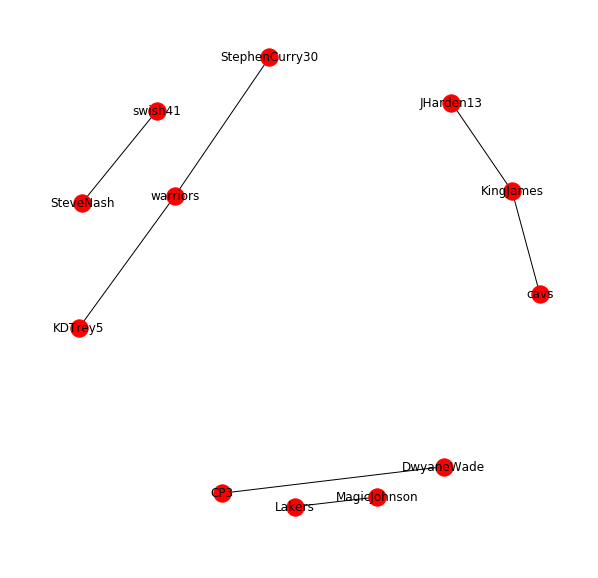

In [51]:
#set figure size and axes
plt.figure(figsize = (10, 10))
plt.axis('off')

#define G
G = nx.Graph()

#useredges without weights
useredges = [('cavs', 'KingJames'), ('cavs', 'KingJames'), ('DwyaneWade', 'CP3'), ('KDTrey5', 'warriors'), ('KingJames', 'JHarden13'), ('Lakers', 'MagicJohnson'),('SteveNash','swish41'),('warriors','KDTrey5'),('warriors','StephenCurry30')]
             
G.add_edges_from(useredges)

pos=nx.spring_layout(G)

#without weights
nx.draw_networkx(G, pos)

Edge weights

cavs-KingJames	6

DwyaneWade-CP3	1

KDTrey5-warriors	2

KingJames-JHarden13	2

Lakers-MagicJohnson	2

SteveNash-swish41	3

warriors-KDTrey5	2

warriors-StephenCurry30	17

#### Test if the graph is connected.

The graph is not connected, as evidenced by the tweet replies and mentions.

In [52]:
nx.is_connected(G) 

False

#### Test if the graph is bipartite.

In [53]:
bipartite.is_bipartite(G)

True

The graph is bipartite.

#### Show the number of nodes and edges and the average degree.

In [54]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 12
Number of edges: 7
Average degree:   1.1667


The average degree connectivity is the average nearest neighbor degree of nodes with degree k. 

The graph is not connected. Therefore, we cannot find a measure for center, diameter, and radius.

#### Show measures for centrality.

In [55]:
nx.betweenness_centrality(G)

{'CP3': 0.0,
 'DwyaneWade': 0.0,
 'JHarden13': 0.0,
 'KDTrey5': 0.0,
 'KingJames': 0.01818181818181818,
 'Lakers': 0.0,
 'MagicJohnson': 0.0,
 'StephenCurry30': 0.0,
 'SteveNash': 0.0,
 'cavs': 0.0,
 'swish41': 0.0,
 'warriors': 0.01818181818181818}

#### Show Ego Networks


In [56]:
nx.ego_graph(G, 'KingJames')
ego_net=nx.ego_graph(G, 'KingJames')
print(nx.info(ego_net))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 2
Average degree:   1.3333


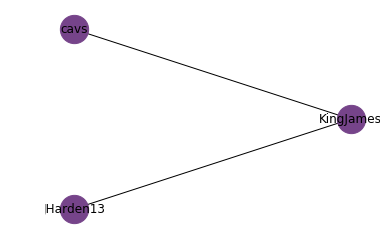

In [57]:
pos=nx.shell_layout(ego_net)
nx.draw_networkx(ego_net, pos, node_size=800, node_color='#76448A')
plt.axis('off')
plt.figure(figsize = (10, 10))

In [58]:
print("\tThe number of nodes connected to KingJames: " + 
      str(len(G.neighbors('KingJames'))) +  "\n")

	The number of nodes connected to KingJames: 2



[Conclusion to Network section]***************************************

The eccentricity of a node v is the maximum distance from v to all other nodes in G. The radius is the minimum eccentricity. The diameter is the maximum eccentricity.

Again the degree and node calculations are verified by the graph projection. A highly connected node has a higher degree and more graph edges.

### Part 6: Conclusion

[Brief summary of each section; explanation of what we learned; comparison to what we predicted; technical and conceptual challenges we faced] 
